# Capstone 3 - Evaluating Train Performance

Using a sample dataset of train schedules from March 2018, I will used unsupervised learning techniques to identify patterns in delayed trains. Then I will used a supervised technique to predict delays.  

In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load Dataset

The dataset is from Kaggle (link below) and includes train trip data from March 2018. The data was gathered by scraping NJ Transit site. It has 13 columns and 256,508 rows.

https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance

In [2]:
path = r"C:\\Users\Raj.Mehta\OneDrive - Wolters Kluwer\Downloads\2018_03.csv"

raw_df = pd.read_csv(path)

In [138]:
raw_df.head(20)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit
5,2018-03-01,3805,6.0,North Elizabeth,109,Elizabeth,41,2018-03-02 01:52:00,2018-03-02 01:52:01,0.016667,departed,Northeast Corrdr,NJ Transit
6,2018-03-01,3805,7.0,Elizabeth,41,Linden,70,2018-03-02 01:58:00,2018-03-02 01:58:05,0.083333,departed,Northeast Corrdr,NJ Transit
7,2018-03-01,3805,8.0,Linden,70,Rahway,127,2018-03-02 02:02:00,2018-03-02 02:01:03,0.000000,departed,Northeast Corrdr,NJ Transit
8,2018-03-01,3805,9.0,Rahway,127,Metropark,83,2018-03-02 02:08:00,2018-03-02 02:08:00,0.000000,departed,Northeast Corrdr,NJ Transit
9,2018-03-01,3805,10.0,Metropark,83,Metuchen,84,2018-03-02 02:13:00,2018-03-02 02:13:10,0.166667,departed,Northeast Corrdr,NJ Transit


Each row represents a trip from one station to the next. Since each row includes the scheduled time and actual time, the first stop is almost always repeated. Only 11 rows do not follow this pattern.

In [91]:
raw_df[(raw_df['stop_sequence'] == 1.0) & (raw_df['from'] != raw_df['to'])].shape

(11, 13)

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256508 entries, 0 to 256507
Data columns (total 13 columns):
date              256508 non-null object
train_id          256508 non-null object
stop_sequence     243028 non-null float64
from              256508 non-null object
from_id           256508 non-null int64
to                256508 non-null object
to_id             256508 non-null int64
scheduled_time    243028 non-null object
actual_time       256508 non-null object
delay_minutes     243028 non-null float64
status            256508 non-null object
line              256508 non-null object
type              256508 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 25.4+ MB


# 2) EDA

In [9]:
# summary of numerical attributes
raw_df.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,243028.000000,256508.000000,256508.000000,243028.000000
mean,7.981661,4150.178474,4159.246971,3.548316
std,5.074539,11708.973053,11718.667560,6.680843
min,1.000000,1.000000,1.000000,0.000000
25%,4.000000,58.000000,58.000000,0.233333
50%,7.000000,104.000000,104.000000,2.100000
75%,11.000000,136.000000,136.000000,4.116667
max,26.000000,43599.000000,43599.000000,111.183333


In [10]:
# summary of categorical attributes

raw_df.describe(include = ['O'])

,date,train_id,from,to,scheduled_time,actual_time,status,line,type
count,256508,256508,256508,256508,243028,256508,256508,256508,256508
unique,31,1539,165,165,39408,178287,3,28,2
top,2018-03-30,0062,New York Penn Station,New York Penn Station,2018-03-28 18:42:00,2018-03-06 23:55:30,departed,Northeast Corrdr,NJ Transit
freq,10311,520,10700,10795,20,41,230066,37692,244186


Date, scheduled_time, and actual time will need to be converted to date time types. Also, train_id will need to be converted into a numerical feature.

In [3]:
# will create a copy of dataframe to start making changes to underlying data

df = raw_df.copy()

In [4]:
# convert categorical attributes

df['scheduled_time'] = pd.to_datetime(df['scheduled_time'])
df['actual_time'] = pd.to_datetime(df['actual_time'])
#df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243028 entries, 0 to 256507
Data columns (total 16 columns):
date              243028 non-null object
train_id          243028 non-null object
stop_sequence     243028 non-null float64
from              243028 non-null object
from_id           243028 non-null int64
to                243028 non-null object
to_id             243028 non-null int64
scheduled_time    243028 non-null object
actual_time       243028 non-null object
delay_minutes     243028 non-null float64
status            243028 non-null object
line              243028 non-null object
type              243028 non-null object
day_of_week       243028 non-null object
ac_time           243028 non-null object
sc_time           243028 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 41.5+ MB


In [22]:
# check for missing values

df.isnull().sum()

date                  0
train_id              0
stop_sequence     13480
from                  0
from_id               0
to                    0
to_id                 0
scheduled_time    13480
actual_time           0
delay_minutes     13480
status                0
line                  0
type                  0
dtype: int64

As the analysis will use delays, I will need values in the scheduled time. Imputing does not seem like a valid option and with 256K rows, I can delete the rows with missing data.

In [5]:
df.dropna(axis=0, subset=['scheduled_time'], inplace = True)

In [6]:
# add a variable with day of the week and time

df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['day_of_week'] = df['day_of_week'].replace([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
#df['departure_time'] = pd.to_datetime(df['scheduled_time']).dt.time
#df['actual_time'] = pd.to_datetime(df['actual_time']).dt.time


Now that the data is relatively clean, I'll begin to explore it visually.

<b> 1 ) What is the percentage of trips by status?

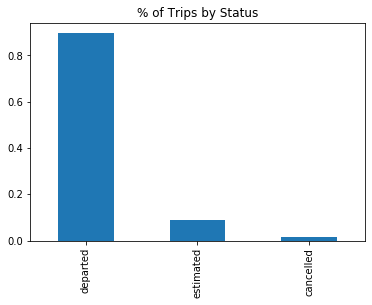

departed     0.895177
estimated    0.087389
cancelled    0.017434
Name: status, dtype: float64

In [73]:
total = len(df.index)
status = df['status'].value_counts() / total

plt.title("% of Trips by Status")
status.plot(kind = 'bar')
plt.show()

status

Only ~2% of trains were cancelled

<b> 2) How many trips were taken in the month?

In [8]:
# will remove first trip from each calculation

df_trips = df.copy()

df_trips = df[(df['from'] != df['to'])]

print('On average, there were {} trips per day'.format(round(df_trips['date'].count() / df_trips['date'].nunique(),0)))

On average, there were 7212.0 trips per day


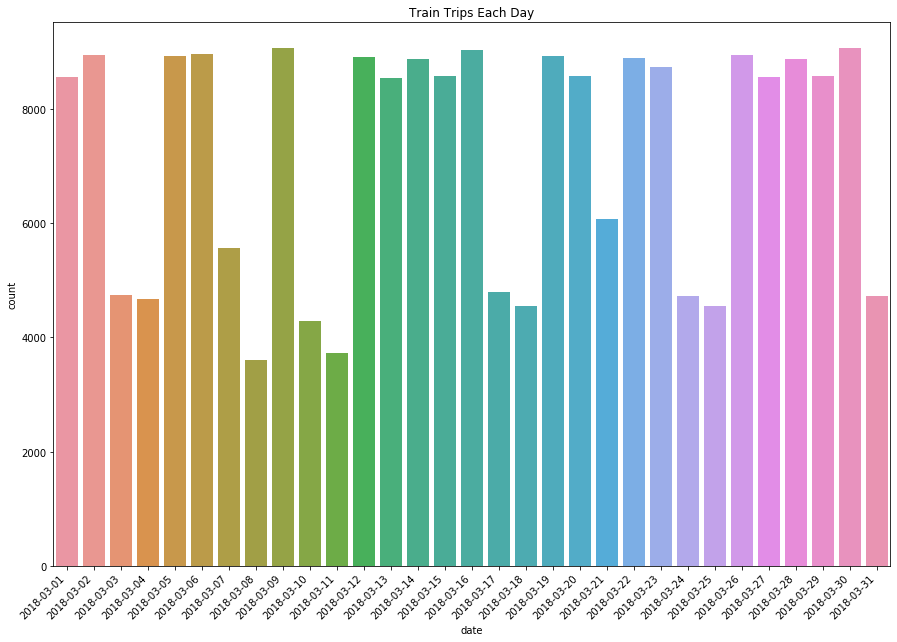

In [94]:
plt.figure(figsize=(15,10))
chart = sns.countplot(x = 'date',data = df_trips)
plt.title('Train Trips Each Day')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.show()

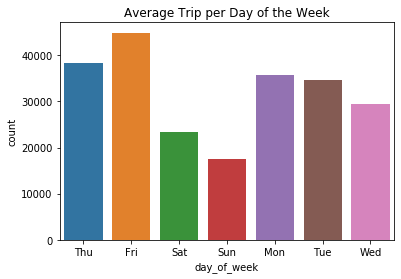

In [95]:
ax = sns.countplot(x="day_of_week",  data=df_trips)
plt.title("Average Trip per Day of the Week")
plt.show()

In [96]:
#avg trips per day
a = pd.DataFrame(df_trips.groupby('day_of_week')['date'].count())
b = pd.DataFrame(df_trips.groupby("day_of_week").agg({ "date": pd.Series.nunique}))
avg_trips = a['date'] / b['date']
avg_trips

day_of_week
Fri    8966.60
Mon    8924.00
Sat    4657.60
Sun    4374.00
Thu    7642.40
Tue    8659.75
Wed    7349.50
Name: date, dtype: float64

On average, there ~7.2K train trips per day.Significantly fewer train trips are on weekends, with Friday having the highest average # of trips. 

<b> 3) What are the most common trips?

In [7]:
from ipysankeywidget import SankeyWidget
from floweaver import *

In [9]:
sankey_df = pd.DataFrame(df_trips.groupby(["from", "to"]).agg({'train_id': np.count_nonzero})).reset_index()
sankey_df= sankey_df.rename(columns={'from': 'source', 'to': 'target', 'train_id': 'value' })

In [10]:
nodes = {
    'start': ProcessGroup(list(sankey_df['source'])), # one (Syria) at the start 
    'end': ProcessGroup(list(sankey_df['target'])), # 7 at the end
}

ordering = [['start'], ['end']]

bundles = [Bundle('start', 'end')]

nodes['start'].partition = Partition.Simple('source', sankey_df['source'].unique())
nodes['end'].partition = Partition.Simple('target', sankey_df['target'].unique())

sdd = SankeyDefinition(nodes, bundles, ordering)

size = dict(width=1200, height=3000)

In [11]:
weave(sdd, sankey_df).to_widget(**size)

SankeyWidget(groups=[{'id': 'start', 'type': 'process', 'title': '', 'nodes': ['start^Aberdeen-Matawan', 'star…

While an interesting visual, it is difficult to glean any insights, so I will subset the data

In [12]:
stop_sequence_df = pd.DataFrame(df_trips.groupby(['stop_sequence','from']).agg({'train_id': np.count_nonzero})).reset_index()

In [13]:
stop_sequence_df[(stop_sequence_df['stop_sequence'] ==2)].sort_values(by = ['train_id'], ascending = False).head()

,stop_sequence,from,train_id
23,2.0,New York Penn Station,3989
11,2.0,Hoboken,3171
39,2.0,Trenton,1302
30,2.0,Princeton,1092
31,2.0,Princeton Junction,1079


In [14]:
nodes = {
    'start': ProcessGroup(['New York Penn Station','Hoboken', 'Trenton','Princeton', 'Princeton Junction']), # one (Syria) at the start 
    'end': ProcessGroup(list(sankey_df['target'])), # 7 at the end
}

ordering = [['start'], ['end']]

bundles = [Bundle('start', 'end')]

nodes['start'].partition = Partition.Simple('source', ['New York Penn Station','Hoboken', 'Trenton','Princeton', 'Princeton Junction'])
nodes['end'].partition = Partition.Simple('target', sankey_df['target'].unique())

sdd = SankeyDefinition(nodes, bundles, ordering)

size = dict(width=2000, height=1500)

In [15]:
weave(sdd, sankey_df).to_widget(**size)

SankeyWidget(groups=[{'id': 'start', 'type': 'process', 'title': '', 'nodes': ['start^New York Penn Station', …

The top origination stations are NY Penn, Hoboken, Trenton, Princeton, and Princeton Junction. Most of these points go two or 3 different locations.

<b> 4) What is the average number of stops?

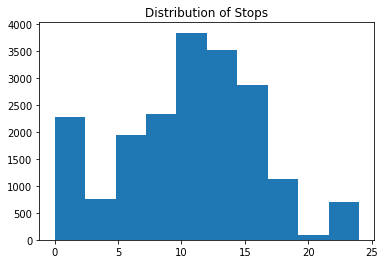

The average number of stops is 10.5


In [122]:
# will need to subtract 1 from stop sequences
stops = df_trips.groupby(['train_id', 'date']).stop_sequence.count() - 1

plt.title("Distribution of Stops")
plt.hist(stops)
plt.show()

print("The average number of stops is {}".format(round(stops.mean(),1)))

<b> 5) What is the average delay?

In [77]:
print("The average delay per trip is {} minutes".format(round(df['delay_minutes'].mean(),1)))

The average delay per trip is 3.5 minutes


In [123]:
# calculate delay across end-to-end trip (i.e., cumulative delay)

cumulative_delay_df = df_trips.groupby(['train_id', 'date']).last()

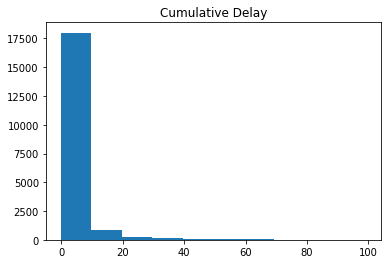

The average cumulative delay is 2.9 minutes


In [127]:
plt.title("Cumulative Delay")
plt.hist(cumulative_delay_df['delay_minutes'])
plt.show()

print("The average cumulative delay is {} minutes".format(round(cumulative_delay_df['delay_minutes'].mean(),1)))



<b> 6) What time do delays typically occur? 

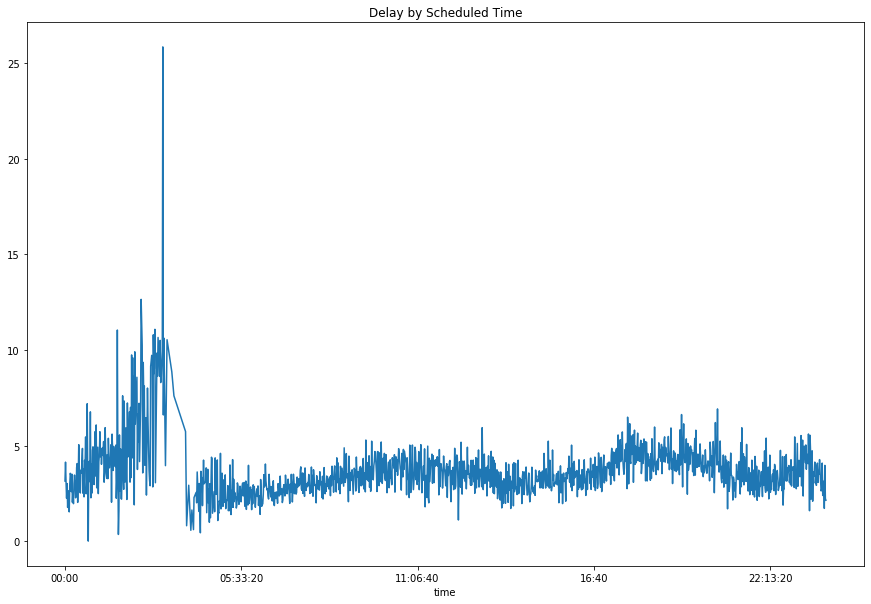

In [167]:
df['actual_time']= df['actual_time'].dt.time
df['scheduled_time']= df['scheduled_time'].dt.time

x = df.groupby('sc_time')['delay_minutes'].mean()


plt.figure(figsize=(15,10))
plt.title("Delay by Scheduled Time")
plt.plot(x)
plt.show()


Delays tend to occur in the late night/ early morning between 12 and 5 am

In [341]:
# Creating bins for time 

#data['Departure_t'] = pd.to_datetime(df.s, format='%H:%M')
#a = data.assign(dept_session=pd.cut(data.Departure_t.dt.hour,[0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening']))
#data['Departure_S'] = a['dept_session']

#df['time_bin'] = pd.cut(x=df['sc_time'], bins= bin_time.astype('timedelta64[ms]', labels=labels))

# 3) Cluster Modeling

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE


In [17]:
# will need to reshape dataset so each row becomes a single end-to-end trip

# identify the last stop and delay in trip
idx = df.groupby(['date','train_id'])['stop_sequence'].transform(max) == df['stop_sequence']
max_df = df[idx]
max_df = max_df[['date','train_id','to', 'delay_minutes']]

# identify the first stop and scheduled start in trip
idx = df.groupby(['date','train_id'])['stop_sequence'].transform(min) == df['stop_sequence']
min_df = df[idx]
min_df = min_df[['date','train_id','from', 'scheduled_time']]

In [18]:
df1 = df.groupby(['date','train_id','line','type','day_of_week']).agg({'stop_sequence': np.count_nonzero}).reset_index()

In [19]:
model_df = pd.merge(df1, max_df, how='left', on=['date', 'train_id'])

In [20]:
model_df = pd.merge(model_df, min_df, how='left', on=['date', 'train_id'])

In [21]:
model_df.shape

(19477, 10)

In [22]:
model_df['sch_time'] = pd.to_datetime(model_df.scheduled_time, format='%H:%M:%S')
a = model_df.assign(dept_session=pd.cut(model_df.sch_time.dt.hour,[-1,5,12,18,28],labels=['Night','Morning','Afternoon','Evening']))
model_df['time_bucket'] = a['dept_session'].astype(str)


For clustering, I am going to drop date, train id, and type from the dataset. I am going to encode the categorical variables and then use PCA to reduce the dimensions before applying clustering.

In [23]:
model_df.drop(['date', 'train_id','type','sch_time','scheduled_time'], axis = 1, inplace=True)

In [24]:
model_df['delay_ind'] = ['1' if x > 0 else '0' for x in model_df['delay_minutes']]

In [25]:
model_df['delay_ind'] = model_df['delay_ind'].replace(['1', '0'], [1,0])
y = model_df['delay_ind']
X = model_df[['line', 'day_of_week', 'stop_sequence', 'to', 'from','time_bucket']]

In [26]:
X = pd.get_dummies(model_df)

In [27]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [28]:
X.shape

(19477, 109)

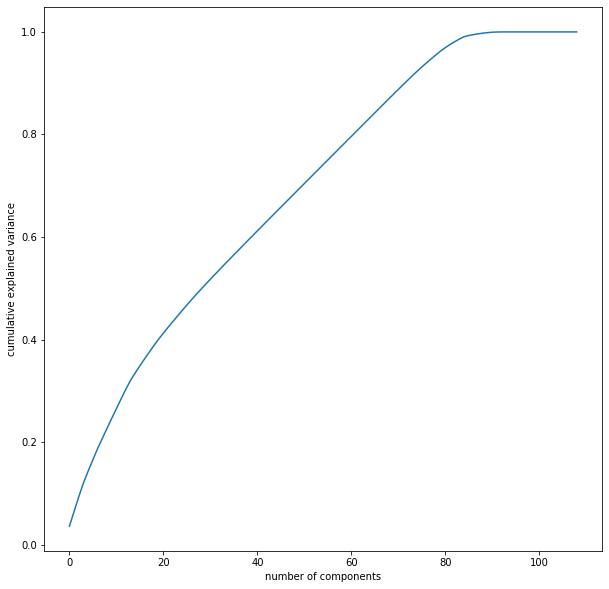

In [363]:
pca = PCA()
pca.fit(X_std)

plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

With the high number of discrete variables, PCA is not very effective in reducing variance. Will conduct a few clustering techniques without using PCA

In [30]:
# will use t-SNE for visualization

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19477 samples in 1.252s...
[t-SNE] Computed neighbors for 19477 samples in 31.556s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19477
[t-SNE] Computed conditional probabilities for sample 2000 / 19477
[t-SNE] Computed conditional probabilities for sample 3000 / 19477
[t-SNE] Computed conditional probabilities for sample 4000 / 19477
[t-SNE] Computed conditional probabilities for sample 5000 / 19477
[t-SNE] Computed conditional probabilities for sample 6000 / 19477
[t-SNE] Computed conditional probabilities for sample 7000 / 19477
[t-SNE] Computed conditional probabilities for sample 8000 / 19477
[t-SNE] Computed conditional probabilities for sample 9000 / 19477
[t-SNE] Computed conditional probabilities for sample 10000 / 19477
[t-SNE] Computed conditional probabilities for sample 11000 / 19477
[t-SNE] Computed conditional probabilities for sample 12000 / 19477
[t-SNE] Computed conditional probabilities for s

In [364]:
clusters = []

for i in range(1,20):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state=123)
    kmeans_pca.fit(X_std)
    clusters.append(kmeans_pca.inertia_)

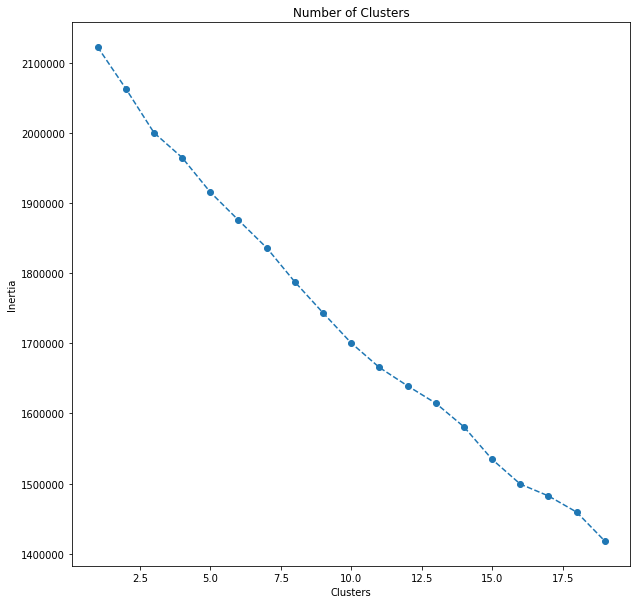

In [365]:
plt.figure(figsize=(10,10))
plt.plot(range(1,20), clusters, marker = 'o', linestyle = '--')
plt.title("Number of Clusters")
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

In [366]:
labels = KMeans(n_clusters=10, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.12419206766923925


Since K-Means uses the euclidean distance measure, it is not an effective means for clustering when the data includes binary variables (from encoding categorical data). Instead, I will try k-modes, which is a technique that can measure similarity across categorical variables.

In [372]:
from kmodes.kmodes import KModes

In [424]:
model_kmm = model_df.copy()
model_kmm.drop(['delay_minutes'], axis = 1, inplace=True)

In [426]:
# determine # of clusters

cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 3, verbose=1)
    kmode.fit_predict(model_kmm)
    cost.append(kmode.cost_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 99464.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1797, cost: 89847.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2242, cost: 84813.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3317, cost: 78981.0
Run 1, iteration: 2/100, moves: 718, cost: 78981.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializ

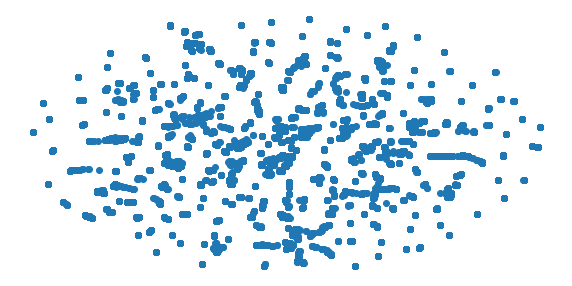

In [32]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

As expected, t-SNE is not helpful with this particular dataset.

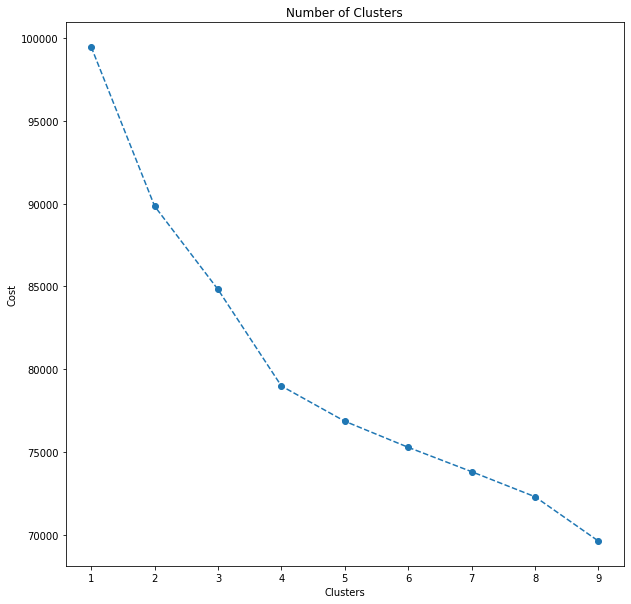

In [428]:
plt.figure(figsize=(10,10))
plt.plot(range(1,10), cost, marker = 'o', linestyle = '--')
plt.title("Number of Clusters")
plt.xlabel('Clusters')
plt.ylabel('Cost')
plt.show()

4 clusters looks like the elbow and may make sense as the K for K-modes application 

In [430]:
# clustering with K = 4
km = KModes(n_clusters=4, init = "Cao", n_init = 3, verbose=1)
clusters = km.fit_predict(model_kmm)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3317, cost: 78981.0
Run 1, iteration: 2/100, moves: 718, cost: 78981.0


In [434]:
# Merge clusters with original data
model_analysis = model_df.reset_index()
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([model_analysis, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index','cluster', 'level_0'], axis = 1)

<b> Analysis for to understand each cluster

In [438]:
combinedDf['cluster_predicted'].value_counts()

0    7603
1    4794
2    4569
3    2511
Name: cluster_predicted, dtype: int64

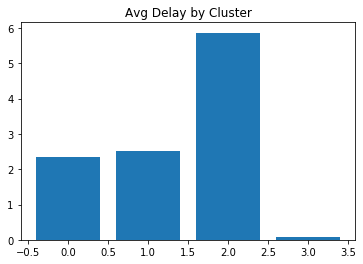

In [450]:
avg_delay = combinedDf.groupby('cluster_predicted')['delay_minutes'].mean()
plt.title("Avg Delay by Cluster")
plt.bar(avg_delay.index, avg_delay)
plt.show()

Cluster 2 has a significantly higher delay on average. Cluster 3 has a minimal delay.

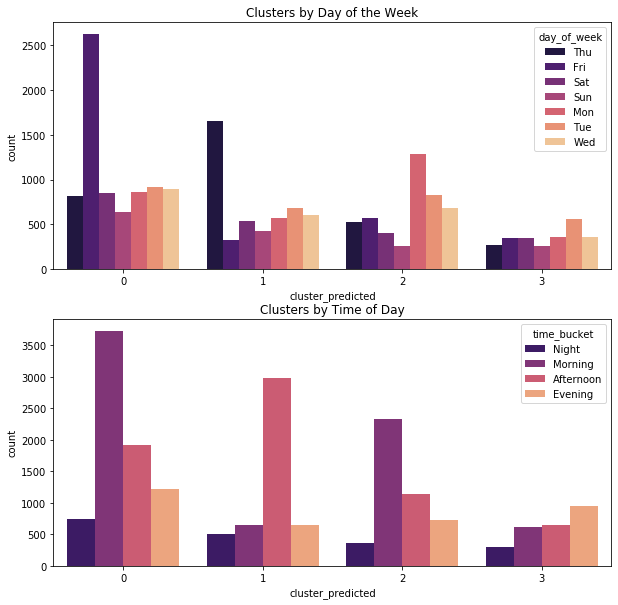

In [439]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(x = 'cluster_predicted', hue = 'day_of_week', data = combinedDf, palette = 'magma')
plt.title('Clusters by Day of the Week')

plt.subplot(2,1,2)
sns.countplot(x = 'cluster_predicted', hue = 'time_bucket', data = combinedDf, palette = 'magma')
plt.title('Clusters by Time of Day')


plt.show()

Clusters 0 and 1 have most the trip volume. Most of the Friday morning trips belong to cluster 0, while cluster 1 has a significant number of afternoon trips

In [440]:
combinedDf.groupby('cluster_predicted').describe()

stop_sequence                                              \
                          count       mean       std  min   25%   50%   75%   
cluster_predicted                                                             
0                        7603.0  13.153755  4.255848  2.0  11.0  13.0  15.0   
1                        4794.0  13.649145  4.035619  2.0  10.0  14.0  16.0   
2                        4569.0  14.593128  4.961600  2.0  11.0  14.0  18.0   
3                        2511.0   4.358423  5.483529  2.0   2.0   2.0   2.0   

                        delay_minutes            ...            delay_ind  \
                    max         count      mean  ...  75%   max     count   
cluster_predicted                                ...                        
0                  26.0        7603.0  2.356988  ...  1.0  99.0    7603.0   
1                  26.0        4794.0  2.503428  ...  2.0  99.0    4794.0   
2                  26.0        4569.0  5.868848  ...  6.0  99.0    4569.0   
3                  26.0        2511.0  0.067304  ...  0.0  13.0    2511.0   

                                                                
                       mean       std  min  25%  50%  75%  max  
cluster_predicted                                               
0                  0.251348  0.433817  0.0  0.0  0.0  1.0  1.0  
1                  0.300584  0.458560  0.0  0.0  0.0  1.0  1.0  
2                  0.878310  0.326963  0.0  1.0  1.0  1.0  1.0  
3                  0.017125  0.129762  0.0  0.0  0.0  0.0  1.0  

[4 rows x 24 columns]

In [441]:
combinedDf.groupby('cluster_predicted').describe(include='O')

line                                 day_of_week         \
                  count unique                top  freq       count unique   
cluster_predicted                                                            
0                  7603     11   Northeast Corrdr  2512        7603      7   
1                  4794     11    No Jersey Coast  1992        4794      7   
2                  4569     11    Morristown Line  1177        4569      7   
3                  2511     11  Princeton Shuttle  2053        2511      7   

                                to                                      from  \
                   top  freq count unique                    top  freq count   
cluster_predicted                                                              
0                  Fri  2619  7603     35                Trenton  1324  7603   
1                  Thu  1647  4794     31  New York Penn Station  1812  4794   
2                  Mon  1286  4569     32  New York Penn Station  1088  4569   
3                  Tue   561  2511     21     Princeton Junction  1092  2511   

                                                      time_bucket         \
                  unique                    top  freq       count unique   
cluster_predicted                                                          
0                     38  New York Penn Station  3078        7603      4   
1                     38            Long Branch  1028        4794      4   
2                     38                Hoboken  1823        4569      4   
3                     23              Princeton  1092        2511      4   

                                    
                         top  freq  
cluster_predicted                   
0                    Morning  3731  
1                  Afternoon  2984  
2                    Morning  2327  
3                    Evening   956

<b>Summary</b>

Due to the data being categorical, I used a K-Modes clustering technique. While 4 clusters appeared to be the optimal K based on reviewing the cost curve, two clusters immediately appeared to be distinct from the other segments. Cluster 2 tended to have trips that were delayed (on average ~5 minute delay). It tended to have more stops and tended to take place on Monday mornings. Cluster 3 experienced the least delays, likely due to having fewer stops and a larger share of evening trips. Clusters 0 and 1 appear similiar based on the average number of stops and delays, however the majority of when the trips occur differ. Cluster 0 had most of the Friday morning trips, while cluster 1 has mostly Thursday afternoon trips.  

# 4) Supervised Technique for Predicting Delayed Trains

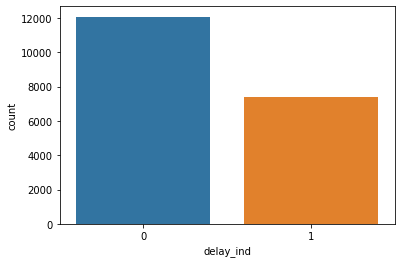

In [451]:
sns.countplot(x = 'delay_ind', data= model_df)
plt.show()

Delays do have a class imbalance which can be addressed within the techniques.

In [459]:
# pre-process data 

#model_prediction = model_df.drop(['delay_minutes','cluster'], axis = 1, inplace=True)

y = model_df['delay_ind']
model_df.drop('delay_ind', axis = 1, inplace=True)
X = pd.get_dummies(model_df)

In [461]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 40)

In [466]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [471]:
lr = LogisticRegression()

params = {}
params['penalty'] = ['l1','l2',None]
params['C']= [0.001, 0.01, 0.1, 1, 10, 100, 10000]
params['max_iter'] = [3000]

CV = GridSearchCV(lr, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [472]:
start_time = time.time()
    
lr_model = CV.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(lr_model.best_params_)

--- 26.638928174972534 seconds ---
{'C': 10000, 'max_iter': 3000, 'penalty': 'l2'}


In [473]:
model_eval(lr_model,X_test, y_test)

[[1999  405]
 [ 872  620]]
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      2404
           1       0.60      0.42      0.49      1492

    accuracy                           0.67      3896
   macro avg       0.65      0.62      0.63      3896
weighted avg       0.66      0.67      0.66      3896

ROC_AUC: 0.624


In [474]:
rfc = RandomForestClassifier()

params = {}
params['max_depth'] = [2,10,20,30,40, 50, None]
params['n_estimators'] = [100,200, 500,750, 1000]
params['criterion'] = ['gini', 'entropy']
params['max_features'] = ['sqrt', 'log2', 'auto']
params['min_samples_leaf'] = [2,5,10,15]
params['min_samples_split'] = [2,5,10,15]

CV = GridSearchCV(rfc, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [475]:
start_time = time.time()
    
rfc_model = CV.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(rfc_model.best_params_)

--- 29303.274629831314 seconds ---
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}


In [476]:
model_eval(rfc_model,X_test, y_test)

[[1946  458]
 [ 711  781]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2404
           1       0.63      0.52      0.57      1492

    accuracy                           0.70      3896
   macro avg       0.68      0.67      0.67      3896
weighted avg       0.69      0.70      0.69      3896

ROC_AUC: 0.666


After using two models (Logistic Regression and Random Forest), RFC proved to have the better F1 score. Due to the number of features (107), the RFC model took 8 hours to run vs. less than a minute for the LR model. While the ROC AUC score is relatively low, pulling in additional data like weather could help potentially explain delays.

# 5) Summary for Analysis

Analyze train trips revealed interesting patterns around delays. While EDA helped identify interesting insights, the unsupervised clustering helped identify common trains for trips that tended to be delayed. Generally, evening trips with fewer stops tended to be pretty safe from delays. Monday morning trips tended to see the most delays, especially with additional stops. In trying to predict delays, the random forest has relatively decent results. The wighted F1 score was 70%. To improve this model, I would like to collect additional data as well as add external features like weather.

# Helper Function

Based on two classification methods, the RFC performed better when trying to predict whether a train would be delayed. 

In [464]:
# model evaluation function

def model_eval(model, x_test, y_test):
    y_predict = model.predict(x_test)
    confusion = confusion_matrix(y_test, y_predict)
    print(confusion)
    print(metrics.classification_report(y_test, y_predict))
    print("ROC_AUC:" ,round(metrics.roc_auc_score(y_test, y_predict),3))
    
    